# Data Sourcing

sourced from: https://www.v-dem.net/data/the-v-dem-dataset/coder-level-v-dem/ 

suggested citation:  V-Dem Dataset:
Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg, Jan Teorell, David Altman, Michael Bernhard, Agnes Cornell, M. Steven Fish, Lisa Gastaldi, Haakon Gjerløw, Adam Glynn, Ana Good God, Sandra Grahn, Allen Hicken, Katrin Kinzelbach, Joshua Krusell, Kyle L. Marquardt, Kelly McMann, Valeriya Mechkova, Juraj Medzihorsky, Natalia Natsika, Anja Neundorf, Pamela Paxton, Daniel Pemstein, Josefine Pernes, Oskar Ryd ́en, Johannes von R ̈omer, Brigitte Seim, Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Aksel Sund- str ̈om, Eitan Tzelgov, Yi-ting Wang, Tore Wig, Steven Wilson and Daniel Ziblatt. 2023. ”V-Dem [Country-Year/Country-Date] Dataset v13” Varieties of Democracy (V-Dem) Project. https://doi.org/10.23696/vdemds23.
and:
Pemstein, Daniel, Kyle L. Marquardt, Eitan Tzelgov, Yi-ting Wang, Juraj Medzihorsky, Joshua Krusell, Farhad Miri, and Johannes von R ̈omer. 2023. “The V-Dem Measurement Model: La- tent Variable Analysis for Cross-National and Cross-Temporal Expert-Coded Data”. V-Dem Working Paper No. 21. 8th edition. University of Gothenburg: Varieties of Democracy Insti- tute.

***the 2023 dataset***


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import scale as scl

### 1. Load Data
***the cell below takes around 5-10 minutes to run***

must have coder_level_ds_v13.csv in the vdem_coderdata (manually add) before running


In [2]:
coder_data = pd.read_csv('../data/vdem_coderdata/coder_level_ds_v13.csv')

/var/folders/hs/8m6m8lrn63g0q8cry5_vxbmm0000gn/T/ipykernel_32402/3260021198.py:1: DtypeWarning: Columns (1310) have mixed types. Specify dtype option on import or set low_memory=False.
  coder_data = pd.read_csv('../data/vdem_coderdata/coder_level_ds_v13.csv')


### 2. Filter for 2022 Data


In [3]:
coder_data["historical_date"] = pd.to_datetime(coder_data["historical_date"])
data_2022 = coder_data[coder_data["historical_date"].dt.year == 2022]

### 3. Filter Question Columns, Rescale all values between 0 and 4

In [4]:
question_columns = [
    col for col in coder_data.columns 
    if col.startswith(("v2", "v3")) and not col.endswith(("_conf", "_beta")) and not col.startswith("v2zz")]

In [ ]:
for col in question_columns:
    coder_data[col] = pd.to_numeric(coder_data[col], errors="coerce")
    scale_max = scl.get_variable_scale(col)
    if scale_max > 2:  
        coder_data[col] = coder_data[col] * (5 / scale_max)

### 4. Assess Number of Coders for each Country and Question

In [ ]:
coder_counts = data_2022.groupby("country_id")[question_columns].count()
coder_counts = coder_counts.reset_index()
coder_counts_long = coder_counts.melt(id_vars=["country_id"], 
                                      var_name="question", 
                                      value_name="num_coders")
coder_counts_long = coder_counts_long.sort_values(by="num_coders", ascending=False)

In [15]:
min_entry = coder_counts_long.loc[coder_counts_long["num_coders"].idxmin()]
max_entry = coder_counts_long.loc[coder_counts_long["num_coders"].idxmax()]
median_value = coder_counts_long["num_coders"].median()
print(f"Minimum: {min_entry['num_coders']} coders for {min_entry['question']} in {min_entry['country_id']}")
print(f"Maximum: {max_entry['num_coders']} coders for {max_entry['question']} in {max_entry['country_id']}")
print(f"Median number of coders per question: {median_value}")

Minimum: 0 coders for v3lglegpup in 84
Maximum: 72 coders for v2zzlibdem in 100
Median number of coders per question: 8.0


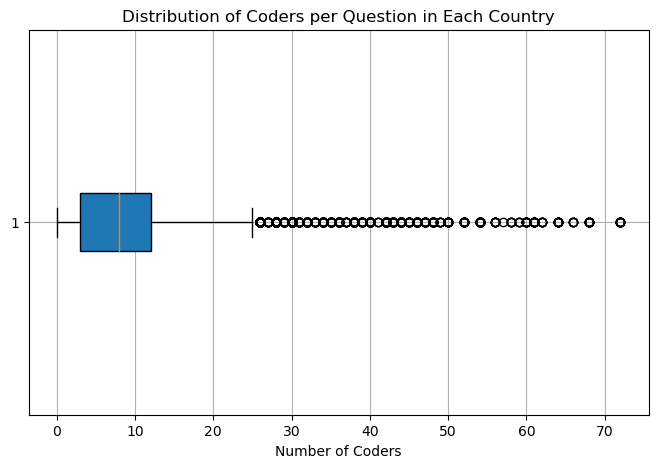

In [18]:
plt.figure(figsize=(8, 5))
plt.boxplot(coder_counts_long["num_coders"], vert=False, patch_artist=True)
plt.xlabel("Number of Coders")
plt.title("Distribution of Coders per Question in Each Country")
plt.grid(True)
plt.show()

### 5. Group by Question and Country, Calculate the Standard Deviations 

In [5]:
std_devs = data_2022.groupby(["country_id"])[question_columns].std().reset_index()
std_devs = std_devs.melt(id_vars=["country_id"], var_name="question", value_name="std_dev")
top_std_devs = std_devs.sort_values(by="std_dev", ascending=False).dropna()

In [6]:
filtered_std_devs = std_devs[std_devs["std_dev"] < 4]
max_5_std = filtered_std_devs.nlargest(5, "std_dev")[["country_id", "question", "std_dev"]]
print("\nMaximum 5 Standard Deviations:")
print(max_5_std)



Maximum 5 Standard Deviations:
       country_id     question   std_dev
70589          70   v2regpower  3.994043
70641         122   v2regpower  3.987480
70669         157   v2regpower  3.949684
70613          94   v2regpower  3.947573
70718          17  v2regproreg  3.947573


In [15]:
median_std = std_devs["std_dev"].median()
print(f"\nMedian Deviation: {median_std}")


Median Deviation: 0.4216370213557839


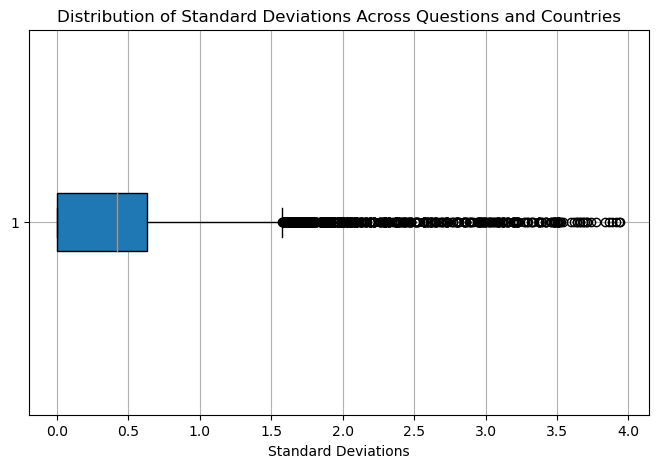

In [16]:
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_std_devs["std_dev"], vert=False, patch_artist=True)
plt.xlabel("Standard Deviations")
plt.title("Distribution of Standard Deviations Across Questions and Countries")
plt.grid(True)
plt.show()

# SAVE SMALL CSV FOR SYED

In [7]:
filtered_std_devs.to_csv('../data/small_download_vdem.csv', index=False)

## TO DO FOR SYED:
1. use filtered_std_devs df > group by country > calculate median standard deviation per country > create box plot of country median values
    - put median in the slide 
    - put box plot in the slides
    - put the  5 countries with the highest median standard deviations in the slies (and the deviation)
2. use filtered_std_devs df > group by question > calculate median standard deviation per question > create box plot of question median values
    - put median in the slide 
    - put box plot in the slides
    - put the  5 questions with the highest median standard deviations in the slies (and the deviation)

In [3]:
## run this to download 
filtered_std_devs = pd.read_csv('../data/small_download_vdem.csv')

country_devs = filtered_std_devs.groupby("country_id")["std_dev"].median().reset_index()
country_devs = country_devs.sort_values(by="std_dev", ascending=False)

print(country_devs)

     country_id   std_dev
46           53  0.534522
83           90  0.534522
117         124  0.522233
139         153  0.516398
164         187  0.516398
..          ...       ...
146         161  0.000000
175         206  0.000000
152         168  0.000000
156         174  0.000000
2             5  0.000000

[179 rows x 2 columns]


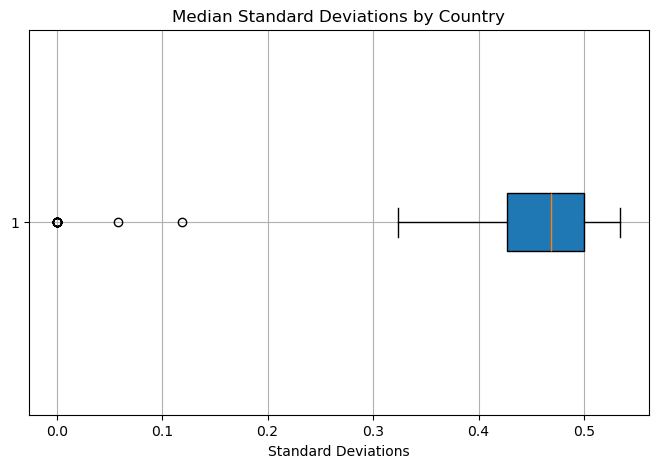

In [4]:
plt.figure(figsize=(8, 5))
plt.boxplot(country_devs["std_dev"], vert=False, patch_artist=True)
plt.xlabel("Standard Deviations")
plt.title("Median Standard Deviations by Country")
plt.grid(True)
plt.show()

In [5]:
questions_devs = filtered_std_devs.groupby("question")["std_dev"].median().reset_index()
questions_devs = questions_devs.sort_values(by="std_dev", ascending=False)

print(questions_devs)

          question   std_dev
359    v2regproreg  2.857738
358     v2regpower  2.755298
138     v2elpaidig  1.350224
357    v2regopploc  1.341641
375    v2regsuploc  1.224745
..             ...       ...
187   v2elsnmrfc_8  0.000000
188   v2elsnmrfc_9  0.000000
192    v2exctlhg_0  0.000000
193    v2exctlhg_1  0.000000
173  v2elsnmrfc_14  0.000000

[438 rows x 2 columns]


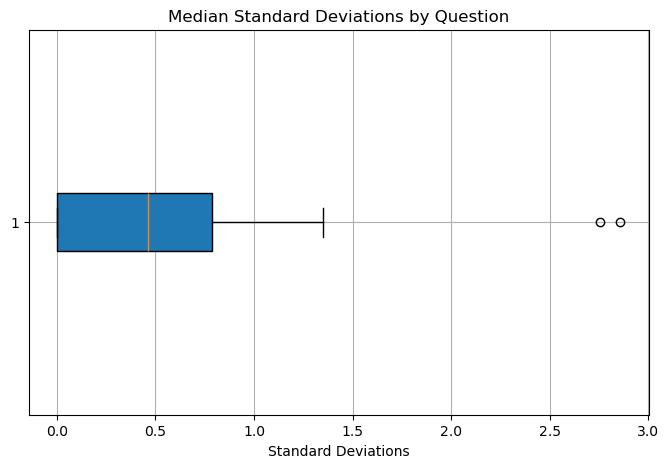

In [6]:
plt.figure(figsize=(8, 5))
plt.boxplot(questions_devs["std_dev"], vert=False, patch_artist=True)
plt.xlabel("Standard Deviations")
plt.title("Median Standard Deviations by Question")
plt.grid(True)
plt.show()

# Cautionary Notes from VDem 
V-Dem is firmly committed to full transparency and release of the data that we have. However, we do ask users to take the following cautions into consideration when using our data.

- The V-Dem Methodology assumes five or more coders for the "contemporary" period starting from 1900, originally coded to 2012. With the updates covering 2013-2022 it has for a few country-variable combinations been impossible to achieve that target. From analysis, we have found that this at times can result in significant changes in point estimates, most likely as a consequence of self-selected attrition of Country Experts, rather than actual meaninful changes in the latent state of a given country. We therefore strongly advise against using point estimates for variable-years where a country has three or fewer ratings. We suggest to filter these out before conducting any type of analysis. Since v7, we include a variable that for every expert- coded variable, suffixed with "_nr", shows the count of ratings per country-year and variable.
- Point estimates can jump around slightly due to the simulation-based nature of the estimation process and expert turnover. Consumers of the data should therefore always be attentive to the uncertainty about the estimates. Further, the uncertainty also provides vital information about the degree to which one can be certain that a change in a score reflects an actual change in the level of the concept being measured.
- We constantly improve the coding of factual data (A) to make it as accurate as possible. This may result in changes at the index-level.
- Observations for Exclusion and Legitimation indicators (section 3.13 and section 3.14) with less than three coders per country-date (*_nr < 3) have been removed. Furthermore, observations for Exclusion indices (section 5.6) have been removed if not at least 3 components have at least 3 coders per country-date.
- Observations for Civic and Academic Space indicators (section 3.15) with less than 3 coders per country-date (*_nr < 3) have been removed.
- hese variables had issues with convergence: v2caconmob, v2cademmob, v2cainsaut, v2capolit, v2catrauni, v2clacjust, v2cltrnslw, v2dlcommon, v2dlencmps, v2elembcap, v2elffelrbin, v2elintim, v2elpdcamp, v2elpeace, v2elpubfin, v2exdjcbhg, v2jupoatck, v2lgdomchm, v2lginvstp, v2peasbgen, v2peasjgeo, v2peasjsoecon, v2pehealth, v2pepwrgeo, v2psprlnks, v2regoppgroupssize, v2smgovab, v2smpolhate, v2x_accountability, v2x_neopat, v2xdl_delib, v2xeg_eqdr, v2xlg_legcon, v2xnp_- client, v2xpe_exlecon, v2xpe_exlgender, v2xpe_exlgeo. Please see individual codebook entries for additional information. For details on interpreting convergence information, please refer to 1.4.5, the Methodology Document and Pemstein et al. (2023).
- We further ask you to use the following percentage variables with caution: 
  - Female journalists (v2mefemjrn)
  -  Weaker civil liberties population (v2clsnlpct)
- Historical V-Dem: In the coding of several Historical V-Dem A-type variables, the histori- cal part of the time series–including 20 years of overlap with the "contemporary" time series (typically 1900-1920)–were conducted completely independently from the existing coding in the original V-Dem dataset, by one or more new coders. For many of these historical variables, we have gone through and checked the consistency of the coding, further scrutinized the sources, and determined which coding represents the most appropriate score after deliberation. We have subsequently made the appropriate adjustments to the data.

For other historical A variables we have yet to finalize this process. For these variables, the scores reported for the overlap period (typically 1900-1920) in the dataset are the "contemporary" V- Dem scores, by default. This means that for some countries, where there is disagreement in the historical and contemporary coding in the starting year for the contemporary time series (typically 1900), there may be artificial changes between that year and the year before that do not necessarily reflect a real-world change in the political system in the country. Hence, we
  advise users to exert caution before running analysis on the entire time series extending across both the historical and contemporary coding periods.


Please also note that for the variables where there is not full correspondence between the his- torical (1789-1920) and contemporary (1900-2022) coding, the historical coding of the variables is also provided in their original form as separate variables, carrying a "v3" rather than a "v2" prefix on the variable tag. These "v3" variables are gathered together with a number of new (A and C type) variables that are currently only coded for the Historical V-Dem sample, in a separate section of the codebook.